# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

***Описание услуг***

Оператор предоставляет два основных типа услуг
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic). 

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

***Описание данных***

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Анализ данных

### Загрузка данных

In [ ]:
import pandas as pd #импортируем Pandas
import numpy as np #импортируем Numpy
import matplotlib.pyplot as plt #для создания графиков
import seaborn #для матрицы корреляции
from sklearn.model_selection import train_test_split # деление на выборки
from sklearn.preprocessing import StandardScaler #для масштабирования
from sklearn.utils import shuffle #для перемешивания данных
from sklearn.linear_model import LogisticRegression #логистичеческая регрессия
from sklearn.model_selection import GridSearchCV #для нахождения оптимальных параметров
from sklearn.metrics import roc_auc_score #для метрики roc-auc
from sklearn import metrics #метрики
from sklearn.ensemble import RandomForestClassifier #случайный лес
from catboost import CatBoostClassifier #импортируем catboost
from sklearn.metrics import accuracy_score #точность 
from sklearn.metrics import f1_score #f1 метрика

In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col = 'customerID') #загружаем contract
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col = 'customerID') #загружаем персональные данные
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col = 'customerID') #информация об интернет-услугах
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col = 'customerID') #информация об телефонии

### Предобработка данных

На данном этапе просмотрим информацию о наших датасетах, проверим на пропуски, аномалии, приведем данные к нужным

#### Contract

In [ ]:
contract.head(5) #выведем несколько строчек контрактов

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract.info() #информация о датасете

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


Как мы видим, существует несколько столбцов данных, посмотрим, что каждый из них значит, перейдем к дальнейшей обработке, изменим типы данных, приведем к стандартному виду, изменим тип переменных.

In [ ]:
contract.columns =  contract.columns.str.lower() #приведем названия к нижнему регистру

In [ ]:
contract["begindate"].value_counts() #уникальные значения конец даты

2014-02-01    366
2019-10-01    237
2019-09-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: begindate, Length: 77, dtype: int64

In [ ]:
contract["begindate"] = pd.to_datetime(contract["begindate"], format = '%Y-%m-%d') #меняем на datetime

In [ ]:
contract["enddate"].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: enddate, dtype: int64

Так как для обучения в дальнейшем нам понадобиться сколько примерно находится пользователь в компании, предлагаю заменить отсутвие значений датой выгрузки данных, а именно 2022-02-01.

In [ ]:
contract.loc[contract['enddate'] == 'No', 'enddate'] = '2020-02-01'
contract['enddate'] = contract['enddate'].astype('datetime64')

In [ ]:
contract["enddate"].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: enddate, dtype: int64

In [ ]:
contract["totalcharges"].value_counts()

20.2       11
           11
19.75       9
19.9        8
19.65       8
           ..
1218.55     1
204.7       1
4837.6      1
2839.65     1
1826.7      1
Name: totalcharges, Length: 6531, dtype: int64

In [ ]:
contract[contract["totalcharges"] == " "] #посмотрим на пропуски,данные коиенты только начали обсуживаться у оператора

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,


In [ ]:
print("Доля пропущенных значений ", len(contract[contract["totalcharges"] == " "]) / len(contract["totalcharges"]))

Доля пропущенных значений  0.001561834445548772


Следовательно, сделаем срез данных, так как таких значений всего 1,5 %, исходя из логики, они не повлияют на общее решение.

In [ ]:
contract = contract.query('totalcharges != " "')

Теперь приведем к типу float.

In [ ]:
contract["totalcharges"]  =  contract["totalcharges"].astype(float)

In [ ]:
contract["paperlessbilling"].value_counts()

Yes    4168
No     2864
Name: paperlessbilling, dtype: int64

Поговорим о представленных данных

1. begindate - Дата начала
2. enddate - Дата окончания
3. type - по месяцу оплата (Month-to-month), или сразу за год (one years)
4. paperlessbilling - Бумажный счет
5. paymentmethod - метод оплаты : электронный или наличными
6. monthlycharges - ежемесячный платеж
7. totalcharges - сумма всех платажей по настоящее время.

In [ ]:
contract["paperlessbilling"].loc[contract["paperlessbilling"] == "Yes"] = 1 #переводим для упрощения работы с признаками
contract["paperlessbilling"].loc[contract["paperlessbilling"] == "No"] = 0

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
contract #проверка

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,1,Mailed check,84.80,1990.50
2234-XADUH,2014-02-01,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45


Прежде чем перейти к следующему датасету, думаю, что целесообразнее записать количество дней сколько клиент уже в компании в отдельный столбец "days"

In [ ]:
contract["days"] = (contract["enddate"] - contract["begindate"]).dt.days #вычитаем две даты, выводим количество дней.
contract

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days
customerID,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,31
5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61
7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61
...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,2020-02-01,One year,1,Mailed check,84.80,1990.50,730
2234-XADUH,2014-02-01,2020-02-01,One year,1,Credit card (automatic),103.20,7362.90,2191
4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,1,Electronic check,29.60,346.45,337


#### Personal

In [ ]:
personal.head(5)#таблица данных о клиентах

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [ ]:
personal.info()#информация о таблице

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [ ]:
personal.columns =  personal.columns.str.lower() #приводим к нижнему регистру столбцы

Данные в таблице представлены несколькими столбцами:

1. gender - пол
2. seniorcitizen - пенсионер или нет
3. partner -  есть ли партнер(муж или жена)
4. dependents - есть ли иждевенцы

In [ ]:
personal['partner'].loc[personal['partner'] == "Yes"] = 1 #создание категориальных признаков
personal['partner'].loc[personal['partner'] == "No"] = 0

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
personal['dependents'].loc[personal['dependents'] == 'Yes'] = 1
personal['dependents'].loc[personal['dependents'] == 'No'] = 0

In [ ]:
personal #проверка

,gender,seniorcitizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,1,0
5575-GNVDE,Male,0,0,0
3668-QPYBK,Male,0,0,0
7795-CFOCW,Male,0,0,0
9237-HQITU,Female,0,0,0
...,...,...,...,...
6840-RESVB,Male,0,1,1
2234-XADUH,Female,0,1,1
4801-JZAZL,Female,0,1,1


#### Internet

In [ ]:
internet.head() #таблица о интернет - услугах

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info() #информация

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [ ]:
internet.columns = internet.columns.str.lower() #приводим к нижнему регистру

In [ ]:
internet["internetservice"].value_counts()

Fiber optic    3096
DSL            2421
Name: internetservice, dtype: int64

In [ ]:
internet.columns

Index(['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')

In [ ]:
for i in internet.columns: #сделаем по категориям, заменим yes на 1 no на 0
    internet[i].loc[internet[i] == "Yes"] = 1
    internet[i].loc[internet[i] == "No"] = 0
    

In [ ]:
internet

,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
customerID,,,,,,,
7590-VHVEG,DSL,0,1,0,0,0,0
5575-GNVDE,DSL,1,0,1,0,0,0
3668-QPYBK,DSL,1,1,0,0,0,0
7795-CFOCW,DSL,1,0,1,1,0,0
9237-HQITU,Fiber optic,0,0,0,0,0,0
...,...,...,...,...,...,...,...
6840-RESVB,DSL,1,0,1,1,1,1
2234-XADUH,Fiber optic,0,1,1,0,1,1
4801-JZAZL,DSL,1,0,0,0,0,0


1. InternetService - Fiber optic или DSL
2. onlinesecurity - есть ли блокировка небезопасных сайтов
3. onlinebackup - есть ли облачное хранилище данных
4. deviceprotection - антивирус
5. techsupport - есть ли выделенная техническая поддержка
6. streamingtv - наличие стримингового телевидения
7. streamingmovies - наличие каталога онлайн фильмов

#### Phone

In [ ]:
phone.head()#информация об услугах телефонии

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [ ]:
phone.info()#информация

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [ ]:
phone.columns = phone.columns.str.lower() #нижний регистр

In [ ]:
phone["multiplelines"].loc[phone["multiplelines"] == "Yes"] = 1
phone["multiplelines"].loc[phone["multiplelines"] == "No"] = 0

MultipleLines  - подключение нескольких линий одновременно.

In [ ]:
phone["multiplelines"].head(5) #проверка

customerID
5575-GNVDE    0
3668-QPYBK    0
9237-HQITU    0
9305-CDSKC    1
1452-KIOVK    1
Name: multiplelines, dtype: object

#### Объединение данных и выделение целевого признака

In [ ]:
import datetime

In [ ]:
contract['begindate']

customerID
7590-VHVEG   2020-01-01
5575-GNVDE   2017-04-01
3668-QPYBK   2019-10-01
7795-CFOCW   2016-05-01
9237-HQITU   2019-09-01
                ...    
6840-RESVB   2018-02-01
2234-XADUH   2014-02-01
4801-JZAZL   2019-03-01
8361-LTMKD   2019-07-01
3186-AJIEK   2014-08-01
Name: begindate, Length: 7032, dtype: datetime64[ns]

In [ ]:
contract['churn'] = (contract['enddate'] != datetime.datetime(2020,2,1)).astype(int)
contract['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [ ]:
contract.head() #проверяем

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days,churn
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,31,0
5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,1036,0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61,1
7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1371,0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61,1


Итак, 0 означает, что клиент не ушел, 1 - ушел. Целевой признак выделен, перед нами задача классификации.

In [ ]:
#Соберем все в один датасет, по id
data = contract.merge(personal,  how = "left", on = "customerID") \
.merge(internet,  how = "left", on = "customerID")  \
.merge(phone,  how = "left", on = "customerID") 
data.head(5)

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days,churn,gender,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,31,0,Female,...,1,0,DSL,0,1,0,0,0,0,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,1036,0,Male,...,0,0,DSL,1,0,1,0,0,0,0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61,1,Male,...,0,0,DSL,1,1,0,0,0,0,0
7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1371,0,Male,...,0,0,DSL,1,0,1,1,0,0,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61,1,Female,...,0,0,Fiber optic,0,0,0,0,0,0,0


In [ ]:
data.info() #информация

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7032 non-null   datetime64[ns]
 1   enddate           7032 non-null   datetime64[ns]
 2   type              7032 non-null   object        
 3   paperlessbilling  7032 non-null   object        
 4   paymentmethod     7032 non-null   object        
 5   monthlycharges    7032 non-null   float64       
 6   totalcharges      7032 non-null   float64       
 7   days              7032 non-null   int64         
 8   churn             7032 non-null   int64         
 9   gender            7032 non-null   object        
 10  seniorcitizen     7032 non-null   int64         
 11  partner           7032 non-null   object        
 12  dependents        7032 non-null   object        
 13  internetservice   5512 non-null   object        
 14  onlinesecurity

In [ ]:
#заменим пропуски на 0, т.е. остутсвие данных услуг
data = data.fillna(0)
print("Количество пропусков :", data.isna().sum())

Количество пропусков : begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
days                0
churn               0
gender              0
seniorcitizen       0
partner             0
dependents          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
multiplelines       0
dtype: int64


In [ ]:
data.head(5)

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,days,churn,gender,...,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,29.85,31,0,Female,...,1,0,DSL,0,1,0,0,0,0,0
5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,1889.50,1036,0,Male,...,0,0,DSL,1,0,1,0,0,0,0
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,61,1,Male,...,0,0,DSL,1,1,0,0,0,0,0
7795-CFOCW,2016-05-01,2020-02-01,One year,0,Bank transfer (automatic),42.30,1840.75,1371,0,Male,...,0,0,DSL,1,0,1,1,0,0,0
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,61,1,Female,...,0,0,Fiber optic,0,0,0,0,0,0,0


На данном этапе можем увидеть, что столбцы обозначающие даты, стоит удалить, т.к. мы уже выделили для них необходимые данные, а именно - количество дней сколько клиент пользуется данной компанией.

In [ ]:
data = data.drop(["begindate", "enddate"], axis = 1) #удаляем ненужные столбцы

## Анализ данных

### Количественные признаки

In [ ]:
data.describe() #информация о данных

,paperlessbilling,monthlycharges,totalcharges,days,churn,seniorcitizen,partner,dependents,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.592719,64.798208,2283.300441,987.538538,0.265785,0.162400,0.482509,0.298493,0.286547,0.344852,0.343857,0.290102,0.384386,0.388367,0.421928
std,0.491363,30.085974,2266.771362,747.153663,0.441782,0.368844,0.499729,0.457629,0.452180,0.475354,0.475028,0.453842,0.486484,0.487414,0.493902
min,0.000000,18.250000,18.800000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,35.587500,401.450000,275.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,70.350000,1397.475000,883.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,89.862500,3794.737500,1676.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,118.750000,8684.800000,2191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


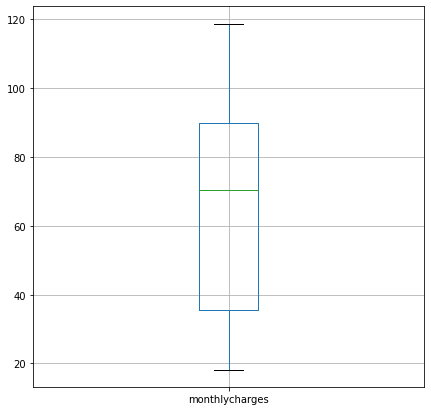

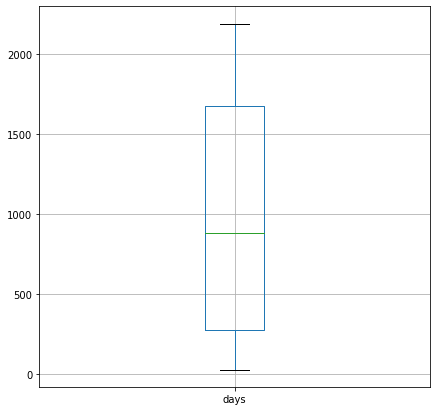

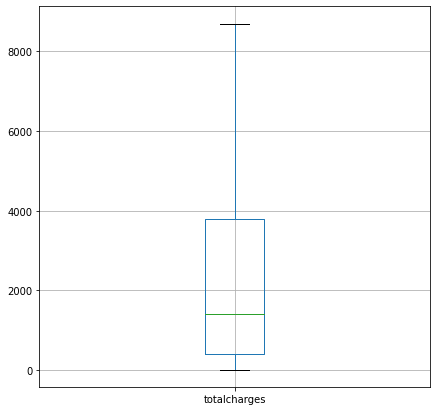

In [ ]:
numerical_signs = ["monthlycharges", "days", "totalcharges"] #построим ящик к усиками для численных признаков
for x in numerical_signs:
    data.boxplot(column = x, grid = True, figsize = (7,7))
    plt.show()

Для ежемесячного платежа, количества дней и общей выручки, построив ящик с усами, можно сделать вывод, что данные в порядке. Для суммы платежа и количества дней -  графики чуть ли не симметричны. Для общей выручки, на мой взгляд -  есть клиенты, которые платят больше всех остальных, а это нормально на мой взгляд. Перейдем к построению гистограмм.

(20.0, 120.0)

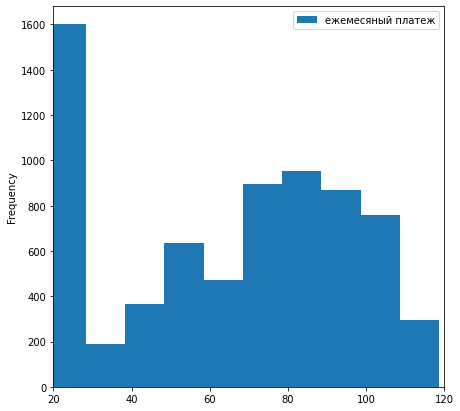

In [ ]:
data.plot( y = "monthlycharges", kind = "hist", label = "ежемесяный платеж", figsize = (7,7))
plt.xlim(20, 120)

Ежемесяные платежи :

1. Виден пик в самом начале, что свидетельствует о наличии огромной стартовой аудитории.
2. Далее пик в от 70 до 100 - это самое распространненное пространство платажей. Boxplot подтвержает, что среднее значение - 70, а пик - 85.
3. Существует часть пользователей, которые скорее всего имеют полный пакет услуг, таких немного, но они присутсвуют.
4. Аномальных значений нет.

(30.0, 2200.0)

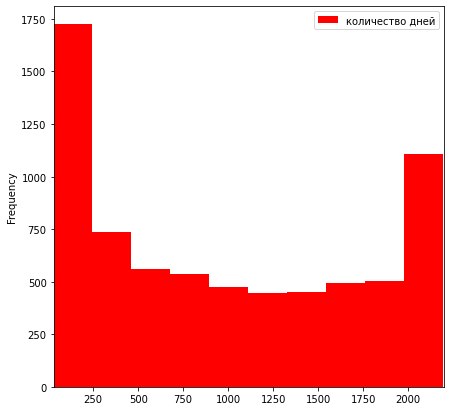

In [ ]:
data.plot( y = "days", kind = "hist", label = "количество дней", color = "red", figsize = (7,7))
plt.xlim(30, 2200)

Количество дней

1. Логично, что основная масса пользуется, услугами около 8 месяцев, потом по каким - то причинам уходят из компании, оставшиеся с высокой долей вероятностью остаются в пользоваться услугами.
2. В нашем датасете достаточно большое количество пользователей, которые пользуются до сих пор услугами.
3. Аномальных значений нет.
4. Пользователи, которые изначально платят больше всех в дальнейшем уходят из компании.

(0.0, 9000.0)

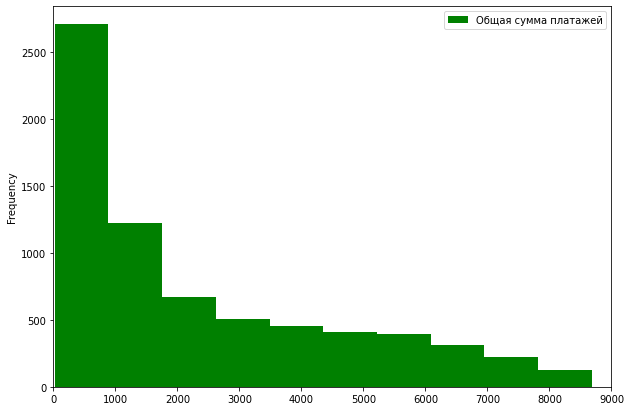

In [ ]:
data.plot( y = "totalcharges", kind = "hist", label = "Общая сумма платажей", color = "green", figsize = (10,7))
plt.xlim(0, 9000)

Общая сумма платажей:

1. График идет на убывание, при этом достаточно равномерно.
2. Аномальных значений нет.

### Категориальные признаки

<AxesSubplot:xlabel='type'>

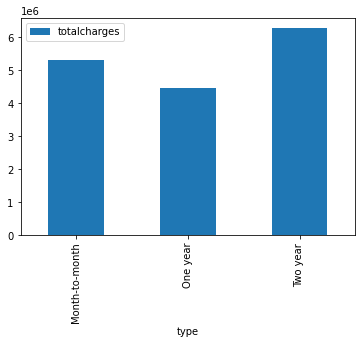

In [ ]:
data.pivot_table(index = "type", values = "totalcharges", aggfunc = "sum").plot(kind = "bar")

Самые большие выручки от тех пользователей, которые используют контракт на 2 года, чуть меньше те, которые платят каждый месяц.

<AxesSubplot:xlabel='paymentmethod'>

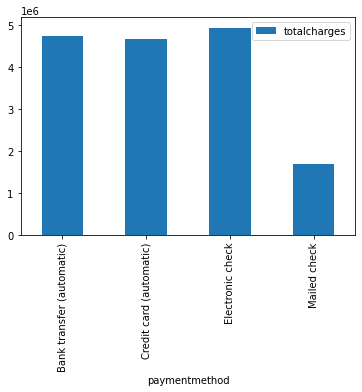

In [ ]:
data.pivot_table(index = "paymentmethod", values = "totalcharges", aggfunc = "sum").plot(kind = "bar")

Больше всего денег приносят электронные платежи, что логично, потому что многие используют автоплатеж и октлючают его редко. К тому же списание происходит автоматически, что удобнее.

<AxesSubplot:xlabel='partner'>

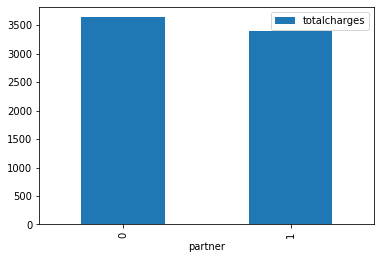

In [ ]:
data.pivot_table(index = "partner", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='partner'>

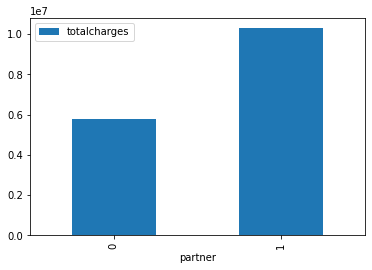

In [ ]:
data.pivot_table(index = "partner", values = "totalcharges", aggfunc = "sum").plot(kind = "bar")

Люди имеющие партнера платят больше, хотя в выборке их количество примерно одинаково.

<AxesSubplot:xlabel='internetservice'>

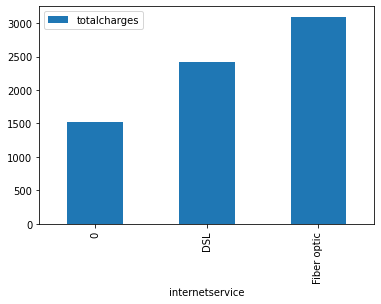

In [ ]:
data.pivot_table(index = "internetservice", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

В основном больше всего денежных средств приносят клиенты, использующие оптику.

<AxesSubplot:xlabel='gender'>

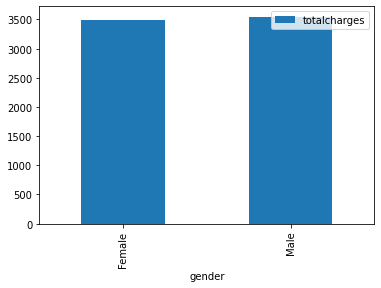

In [ ]:
data.pivot_table(index = "gender", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='gender'>

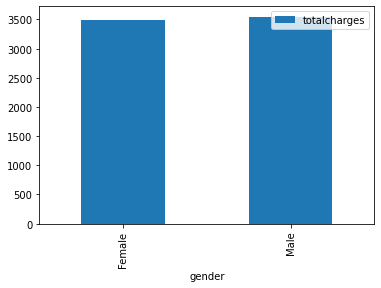

In [ ]:
data.pivot_table(index = "gender", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

Мужчин и женщин примерно одинаково  и платят так же)

<AxesSubplot:xlabel='seniorcitizen'>

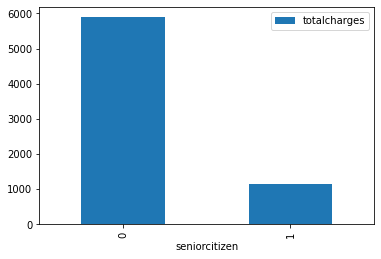

In [ ]:
data.pivot_table(index = "seniorcitizen", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

Доля пенсионеров небольшая в выборке.

<AxesSubplot:xlabel='dependents'>

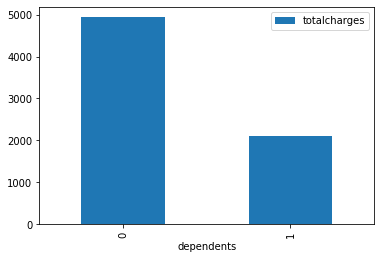

In [ ]:
data.pivot_table(index = "dependents", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

Иждвинцев немного у пользователей.

<AxesSubplot:xlabel='onlinesecurity'>

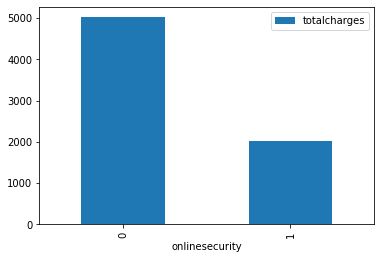

In [ ]:
data.pivot_table(index = "onlinesecurity", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='onlinebackup'>

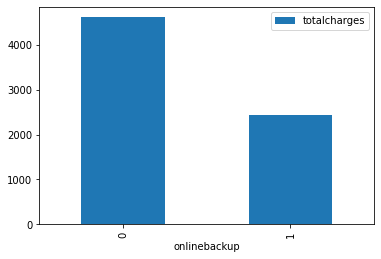

In [ ]:
data.pivot_table(index = "onlinebackup", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='deviceprotection'>

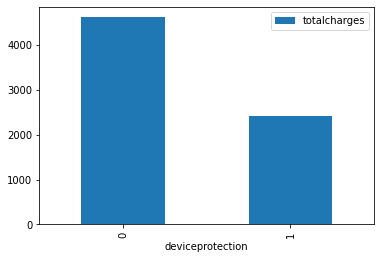

In [ ]:
data.pivot_table(index = "deviceprotection", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='techsupport'>

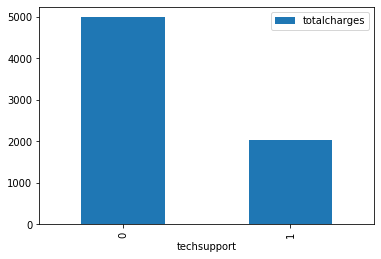

In [ ]:
data.pivot_table(index = "techsupport", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='streamingtv'>

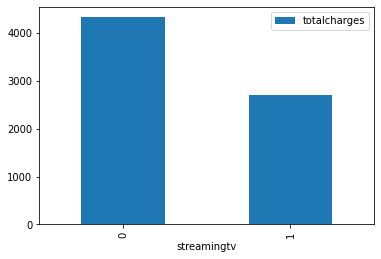

In [ ]:
data.pivot_table(index = "streamingtv", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='streamingmovies'>

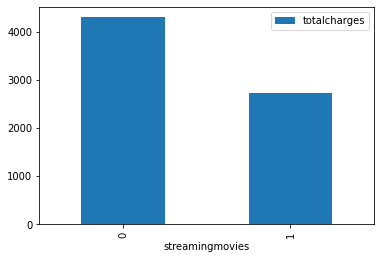

In [ ]:
data.pivot_table(index = "streamingmovies", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

<AxesSubplot:xlabel='multiplelines'>

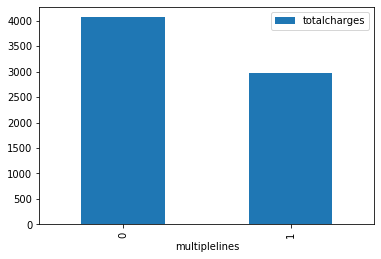

In [ ]:
data.pivot_table(index = "multiplelines", values = "totalcharges", aggfunc = "count").plot(kind = "bar")

Дополнительными услугами почти не пользуются, не считая онлайн-стримнговых сервисов а так же многоканальность, их используют чаще, что логично, потому что сейчас пользователям проще покупать услуги телевидения, онлайн-кинотеатров и тому подобное у одного оператора, чтобы не иметь кучу разных подписок.

Относительно целевого признака :

<AxesSubplot:xlabel='type,churn'>

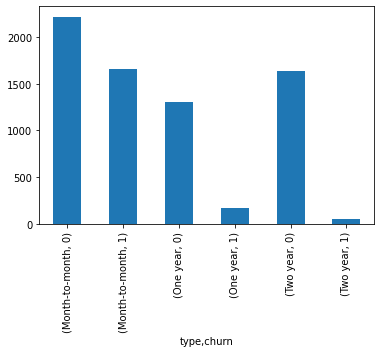

In [ ]:
data.groupby(["type", "churn"])["churn"].count().plot(kind = "bar")

Количество активных пользователей, c увеличением  длительности контракта падает.

<AxesSubplot:xlabel='gender,churn'>

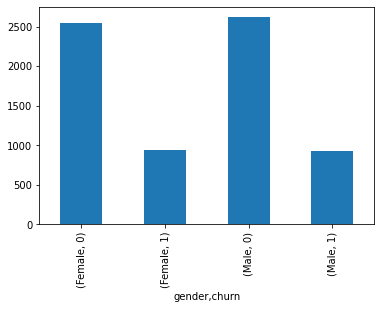

In [ ]:
data.groupby(["gender", "churn"])["churn"].count().plot(kind = "bar")

Количество мужчин и женщин отказавшихся от подписок и активных, примерно одинаково.

<AxesSubplot:xlabel='type,churn'>

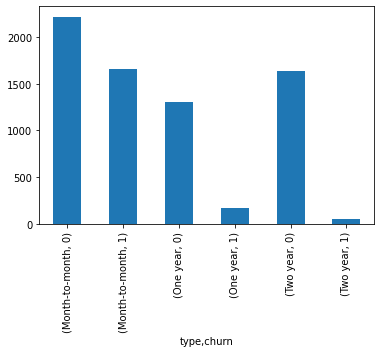

In [ ]:
data.groupby(["type", "churn"])["churn"].count().plot(kind = "bar")

Ушедшие клиенты в основном используют короткосрочные контракты или на 2 года.

<AxesSubplot:xlabel='paymentmethod,churn'>

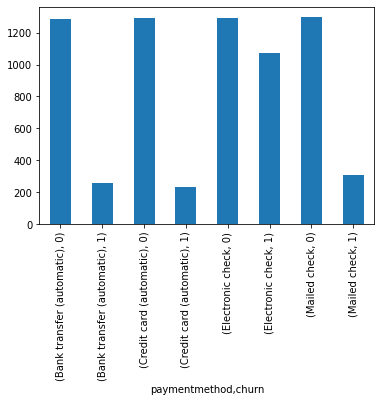

In [ ]:
data.groupby(["paymentmethod", "churn"])["churn"].count().plot(kind = "bar")

Использующие электронные платежи уходили активно, что странно, практика показывает обратный случай.

### Матрица корреляции

<AxesSubplot:>

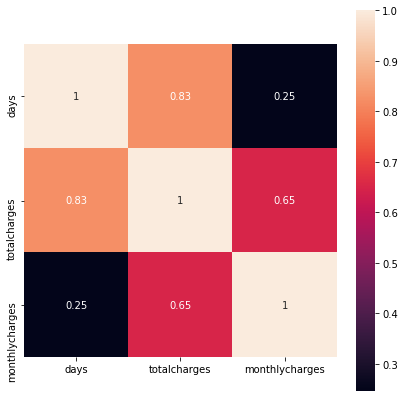

In [ ]:
corr_matrix = data.loc[:,["days","totalcharges","monthlycharges"]].corr()  #сама матрица
plt.figure(figsize=(7,7)) #для отображения нормального, а не маленького
seaborn.heatmap(corr_matrix, annot=True, square=True) #построение

Заметим тот факт, что количество дней очень сильно влияет на общую выручку, поэтому чтобы избавиться от мультикорреляции - предлагаю экспериментально удалить столбец "totalcharges"

In [ ]:
data = data.drop("totalcharges", axis = 1) #удаляем

In [ ]:
data #проверяем

,type,paperlessbilling,paymentmethod,monthlycharges,days,churn,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,31,0,Female,0,1,0,DSL,0,1,0,0,0,0,0
5575-GNVDE,One year,0,Mailed check,56.95,1036,0,Male,0,0,0,DSL,1,0,1,0,0,0,0
3668-QPYBK,Month-to-month,1,Mailed check,53.85,61,1,Male,0,0,0,DSL,1,1,0,0,0,0,0
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1371,0,Male,0,0,0,DSL,1,0,1,1,0,0,0
9237-HQITU,Month-to-month,1,Electronic check,70.70,61,1,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,1,Mailed check,84.80,730,0,Male,0,1,1,DSL,1,0,1,1,1,1,1
2234-XADUH,One year,1,Credit card (automatic),103.20,2191,0,Female,0,1,1,Fiber optic,0,1,1,0,1,1,1
4801-JZAZL,Month-to-month,1,Electronic check,29.60,337,0,Female,0,1,1,DSL,1,0,0,0,0,0,0


## Подготовка к обучению и обучение

### Подготовка данных

Применим OHE, чтобы обработать категориальные признаки, обработаем их в численный метод, чтобы провести обучение, первоначальные признаки сбросим, чтобы не попасть в дамми-ловушку.

In [ ]:
data.head(5)

,type,paperlessbilling,paymentmethod,monthlycharges,days,churn,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,31,0,Female,0,1,0,DSL,0,1,0,0,0,0,0
5575-GNVDE,One year,0,Mailed check,56.95,1036,0,Male,0,0,0,DSL,1,0,1,0,0,0,0
3668-QPYBK,Month-to-month,1,Mailed check,53.85,61,1,Male,0,0,0,DSL,1,1,0,0,0,0,0
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1371,0,Male,0,0,0,DSL,1,0,1,1,0,0,0
9237-HQITU,Month-to-month,1,Electronic check,70.70,61,1,Female,0,0,0,Fiber optic,0,0,0,0,0,0,0


In [ ]:
data = pd.get_dummies(data, drop_first = True) #первоначальные столбцы удаляем

In [ ]:
data["churn"].value_counts() #смотрим количество уникальных значений

0    5163
1    1869
Name: churn, dtype: int64

In [ ]:
delta_klass = sum(data["churn"]/len(data))/ (1-sum(data["churn"]/len(data)))
print("Отношение положительного класса к отрицательному классу - ", delta_klass)

Отношение положительного класса к отрицательному классу -  0.36199883788494286


Cледовательно, присутвует дисбаланс классов 3:1.

###  Деление на выборки, масштабирование

In [ ]:
data["monthlycharges"] = data["monthlycharges"].astype('int64') #приводим к целочисленным значениям, чтобы избежать ошибки
#data["totalcharges"] = data["totalcharges"].astype('int64')

In [ ]:
features = data.drop("churn", axis = 1) #признаки
target = data["churn"] #целевой признак

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25
                                                                            , random_state = 250722) #деление на трэйн и тест

In [ ]:
columns_1 = ["monthlycharges", "days"] #численные признаки

In [ ]:
#масштабирование признаков
scaler = StandardScaler()

scaler.fit(features_train[columns_1])

features_train[columns_1] = scaler.transform(features_train[columns_1])
features_test[columns_1] = scaler.transform(features_test[columns_1])

/tmp/ipykernel_63/1665881791.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[columns_1] = scaler.transform(features_train[columns_1])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_63/1665881791.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

После масштабирования перейдем к работе с дисбалансом классов

In [ ]:
features_zeros = features_train[target_train == 0] #делим выборку на полоижительные и отрицательные объекты
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones= target_train[target_train == 1]
repeat = 3 #так как дисбаланс 1 к 3

In [ ]:
#копируем несколько раз положительные объекты
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)  #соединяем таблицы
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat) 

In [ ]:
#перемешать данные
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=250722) 

### Обучение моделей

#### LogisticRegression

In [ ]:
model_lr = LogisticRegression(random_state = 250722, solver='lbfgs', n_jobs=-1) #загружаем модель
params = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]} #загружаем параметры
model_lr = GridSearchCV(model_lr, params, cv=5, verbose = 0, scoring='roc_auc') #загружаем в grid данные

In [ ]:
%%time
model_lr.fit(features_upsampled, target_upsampled) #обучение

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: Fi

CPU times: user 8.41 s, sys: 22.5 s, total: 31 s
Wall time: 31 s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1, random_state=250722),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [ ]:
model_lr.best_estimator_

LogisticRegression(C=1000, n_jobs=-1, random_state=250722)

In [ ]:
predict_lr = model_lr.best_estimator_.predict_proba(features_test)[:,1] #находим предсказания вероятности

In [ ]:
roc_auc_score(target_test, predict_lr)

0.8412372318168766

#### RandomForest

In [ ]:
model = RandomForestClassifier(random_state=250722)
params = {'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 10], 'min_samples_leaf': [2, 10],
              'n_estimators': [10,30,50,70,80,90, 100] }
model_rf = GridSearchCV(model, params, cv=5, scoring='roc_auc')

In [ ]:
%%time
model_rf.fit(features_upsampled, target_upsampled)

CPU times: user 2min, sys: 850 ms, total: 2min
Wall time: 2min 1s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=250722),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [10, 30, 50, 70, 80, 90, 100]},
             scoring='roc_auc')

In [ ]:
model_rf.best_params_

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
predict_rf = model_rf.best_estimator_.predict_proba(features_test)[:,1] #находим предсказания

In [ ]:
roc_auc_score(target_test, predict_rf)

0.8469959387947656

#### CatBoost

In [ ]:
model_ct = CatBoostClassifier(random_state=250722, verbose=0)

params= {
    'learning_rate': [0.1, 0.3, 0.4],
    'iterations': [50, 80, 100],
    'l2_leaf_reg': [3, 6, 9]}


In [ ]:
%%time
model_ct = GridSearchCV(model_ct, params, cv=5, scoring='roc_auc')
model_ct.fit(features_upsampled, target_upsampled)

CPU times: user 24.6 s, sys: 1.23 s, total: 25.8 s
Wall time: 1min 30s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f2764a742e0>,
             param_grid={'iterations': [50, 80, 100], 'l2_leaf_reg': [3, 6, 9],
                         'learning_rate': [0.1, 0.3, 0.4]},
             scoring='roc_auc')

In [ ]:
predict_ct = model_ct.best_estimator_.predict_proba(features_test)[:,1] #находим предсказания

In [ ]:
print("ROC-AUC на тестовой выборке:",roc_auc_score(target_test, predict_ct))

ROC-AUC на тестовой выборке: 0.9159059769454815


In [ ]:
print("Точность на тестовой выборке:",accuracy_score(target_test,
                                                     model_ct.predict(features_test)))

Точность на тестовой выборке: 0.8395904436860068


In [ ]:
print("F1 на тестовой выборке:",f1_score(target_test,
                                                     model_ct.predict(features_test)))

F1 на тестовой выборке: 0.724609375


### Важность фактооров 

In [ ]:
importances = pd.DataFrame(model_ct.best_estimator_.feature_importances_ ,
                           index = features_train.columns, 
                           columns = ["total"])

In [ ]:
importances = importances.sort_values(by = 'total', ascending = False)

<AxesSubplot:title={'center':'Важность факторов'}>

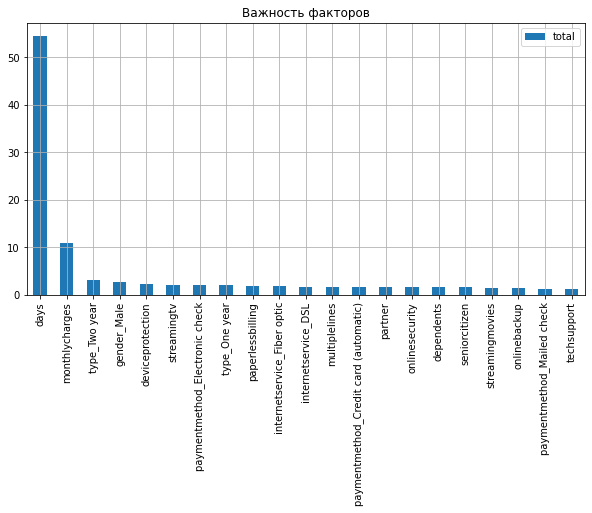

In [ ]:
importances.plot(kind = "bar",
                 figsize = (10,5),
                 grid = True,
                 title = "Важность факторов" )

In [ ]:
importances

,total
days,54.497334
monthlycharges,10.868840
type_Two year,3.203340
gender_Male,2.662219
deviceprotection,2.228147
streamingtv,2.129574
paymentmethod_Electronic check,2.063067
type_One year,2.047020
paperlessbilling,1.840398
internetservice_Fiber optic,1.827890


На графике выше продемонстрирован рейтинг важности признаков, как и ожидалось - самые важные факторы - это количество дней в компании и ежемесячный платеж. 

## Вывод

В рамках данного проекта, были исследованы данные о пользователях, пользующиеся неким оператором связи, в результате чего был проведен аналализ данных и построены различные модели обучения, исходя из чего можно сделать выводы о том, что :

1. Данные были успешно предобработы, дубликатов явных и неявных не было представлено, удалены неявные пропуски, заполенены пропущенные значения.
2. В результате анализа данных, изнчально было очевидно, что ежемесячный платеж, общее количество дней использования оператора и общая сумма -  самые значимые факторы. Дополнительные услуги, уже на данном этапе показались нам не столь важные, т.к. доли клиентов с услугой и без услугой, оставались или уходили в компании примерно одинаково.
3. Построив матрицу корреляции было принято решение удалить численный признак, а именно общая выручка, т.к. она коррелирует с высоким значением, а именно - 0.86, по количеству дней в компании.
4. Была решена проблема дисбаланса класса, применен метод OHE для категориальных признаков.
5. Были построены несколько моделей обучения, а именно LogisticRegression, RandomForest, CatBoost.
6. CatBoost на матрике ROC-AUC показала самый высокий результат : 0.9159
7. Точность : 0.8395, F1 : 0.7246
8. Самые важные факторы - это количество дней и ежемесячный платеж.
9. Мои мысли : на мой взгляд, слишком велико значение 2ух численных факторов, компании следует использовать различные промокомпании или усилить конкуретноспособность различных дополнительных "плюшек", чтобы оставлять клиентов не только "по привычке" (дата) и денежного вопроса (ежемесячный платеж), но и привлекать его по различным продуктам внутри компании. Те же стриминговые сервисы и защита влияют на лояльность пользователя, нужно, на мой взгляд, проработать этот вопрос, чтобы в дальнейшем говорить о встаивания модели предсказания в копмпанию, могу быть не прав, но мысль так легла.